In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch

# 1.Read Data

In [230]:
text_data = pd.read_csv('cleaned_text.csv')
print(text_data.shape)
text_data.head()

(17880, 2)


,cleaned_text,fraudulent
0,marketing intern new york marketing food and c...,0
1,customer service cloud video production auckla...,0
2,commissioning machinery assistant cma wever va...,0
3,account executive washington washington sales ...,0
4,bill review manager fort worth spot source sol...,0


In [218]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [231]:
X_train, X_test, y_train, y_test = train_test_split(text_data['cleaned_text'], 
                                                    text_data['fraudulent'], 
                                                    test_size=0.3, 
                                                    random_state=666)

print(f"Train X shape: {X_train.shape}")
print(f"{y_train.value_counts()}")
print(f"positive rate: {y_train.value_counts()[1] / y_train.shape[0]:.4f}\n")
print(f"Test X shape: {X_test.shape}")
print(f"{y_test.value_counts()}")
print(f"positive rate: {y_test.value_counts()[1] / y_test.shape[0]:.4f}\n")

Train X shape: (12516,)
0    11915
1      601
Name: fraudulent, dtype: int64
positive rate: 0.0480

Test X shape: (5364,)
0    5099
1     265
Name: fraudulent, dtype: int64
positive rate: 0.0494



In [234]:
train_data = pd.concat([X_train, y_train], axis=1)
print(f"Before resampling, the train X shape is {train_data.shape}, "
      f"class distribution is {train_data['fraudulent'].value_counts()}")

train_resampled_positive = resample(
    train_data[train_data['fraudulent']==1],         
    n_samples=train_data[train_data['fraudulent']==0].shape[0],
    replace=True
)


train_data = pd.concat([train_data[train_data['fraudulent']==0], train_resampled_positive])
print(train_data.shape)
print(train_data['fraudulent'].value_counts())

Before resampling, the train X shape is (12516, 2), class distribution is 0    11915
1      601
Name: fraudulent, dtype: int64
(23830, 2)
0    11915
1    11915
Name: fraudulent, dtype: int64


In [267]:
X_train, y_train = train_data['cleaned_text'], train_data['fraudulent']
test_data = pd.concat([X_test, y_test], axis=1)

In [289]:
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

In [314]:
test_data

,index,cleaned_text,fraudulent
0,13777,software engineer visakhapatnam product develo...,0
1,13321,head online marketing munich non tech hello wo...,0
2,2391,graduates english teacher abroad conversationa...,0
3,6857,business development manager banking investmen...,0
4,3520,business development manager eng london studen...,0
...,...,...,...
5359,4295,english teacher abroad charles help teachers g...,0
5360,5401,sales associate new york proenza schouler look...,0
5361,15432,web designer wellington permanent silver strip...,0
5362,3148,executive assistant crystal city for more than...,0


In [296]:
merge_data = pd.concat([train_data, test_data])
merge_data.reset_index(inplace=True, drop=True)
merge_data.loc[train_data.shape[0]:]

,level_0,index,cleaned_text,fraudulent
23830,NaN,13777,software engineer visakhapatnam product develo...,0
23831,NaN,13321,head online marketing munich non tech hello wo...,0
23832,NaN,2391,graduates english teacher abroad conversationa...,0
23833,NaN,6857,business development manager banking investmen...,0
23834,NaN,3520,business development manager eng london studen...,0
...,...,...,...,...
29189,NaN,4295,english teacher abroad charles help teachers g...,0
29190,NaN,5401,sales associate new york proenza schouler look...,0
29191,NaN,15432,web designer wellington permanent silver strip...,0
29192,NaN,3148,executive assistant crystal city for more than...,0


In [311]:
split_index = train_data.shape[0]
split_index

23830

In [315]:
# train data
merge_data.loc[:split_index-1]['fraudulent'].value_counts()

0    11915
1    11915
Name: fraudulent, dtype: int64

In [316]:
# test data
merge_data.loc[split_index:]['fraudulent'].value_counts()

0    5099
1     265
Name: fraudulent, dtype: int64

# 2.Data Preparation

In [29]:
import os
import tqdm

from nltk.tokenize import word_tokenize
from collections import defaultdict
from gensim.models import Word2Vec, KeyedVectors 
from gensim.test.utils import datapath

## 2.1 Word Embedding

In [299]:
def tokenize(text):
    word2idx = {}
    idx = 2
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    tokenized_text = []
    max_len = 0
    
    for row in text:
        tokenized_row = word_tokenize(row)
        tokenized_text.append(tokenized_row)
        max_len = max(max_len, len(tokenized_row))
        
        for word in tokenized_row:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    
    return tokenized_text, word2idx, max_len

In [300]:
tokenized_text, word2idx, max_len = tokenize(merge_data['cleaned_text'])
print(f"max_len: {max_len}")
print(f"First five texts: {tokenized_text[:5]}")

max_len: 1795
First five texts: [['entry', 'level', 'sales', 'jacksonville', 'general', 'summary', 'achieves', 'maximum', 'sales', 'profitability', 'growth', 'and', 'account', 'penetration', 'within', 'assigned', 'territory', 'and', 'market', 'segment', 'effectively', 'selling', 'the', 'company', 'products', 'and', 'related', 'services', 'personally', 'contacts', 'and', 'secures', 'new', 'business', 'accounts', 'customers', 'core', 'functions', 'promotes', 'sells', 'secures', 'orders', 'from', 'existing', 'and', 'prospective', 'customers', 'through', 'relationship', 'based', 'approach', 'demonstrates', 'products', 'and', 'services', 'existing', 'potential', 'customers', 'and', 'assists', 'themin', 'selecting', 'those', 'best', 'suited', 'their', 'needs', 'details', 'function', 'establishes', 'develops', 'and', 'maintains', 'business', 'relationships', 'withcurrent', 'customers', 'and', 'prospective', 'customers', 'the', 'assigned', 'territory', 'market', 'segment', 'generate', 'new', '

In [353]:
def text_adjust_encode(tokenized_text, word2idx, max_len):
    res = []
    for row in tokenized_text:
        row.extend((max_len - len(row)) * ['<pad>'])
        res.append([word2idx.get(token, 1) for token in row])
    
    return np.array(res)

input_index = text_adjust_encode(tokenized_text, word2idx, max_len)
input_index[0]

array([2, 3, 4, ..., 0, 0, 0])

In [306]:
# print(input_index.shape)
# print(merge_data.shape)

(29194, 1795)
(29194, 4)


In [15]:
# load pre-trained word embeddings, word2vec
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [302]:
def embedding(word2idx, word2vec):
    word_embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), 300))
    word_embeddings[0] = np.zeros(300)
    cnt = 2
    
    for word in word2idx:
        if word in word2vec:
            word_embeddings[word2idx[word]] = word2vec[word]
            cnt += 1
            
    print(f"{cnt} out of {len(word2idx)} tokens have been found in word2vec pretrained embeddings")
    return torch.tensor(word_embeddings, requires_grad=False, dtype=torch.float32)

embeddings = embedding(word2idx, word2vec)
embeddings[2]

26161 out of 47347 tokens have been found in word2vec pretrained embeddings


tensor([-0.1279, -0.0771, -0.2637, -0.0894,  0.3340,  0.2285, -0.1504, -0.1523,
         0.0193, -0.1152,  0.0031, -0.1855,  0.0664, -0.4297, -0.1582, -0.1865,
         0.0962,  0.0091,  0.0684, -0.1680,  0.2197, -0.0084, -0.2373, -0.2236,
        -0.1582, -0.1602, -0.0077,  0.0014,  0.0908, -0.0540,  0.0413, -0.3535,
         0.1074, -0.1641,  0.2354, -0.2314, -0.0347, -0.0566, -0.0742, -0.1738,
        -0.0640,  0.0154,  0.3965,  0.2383,  0.1660, -0.1416, -0.2598,  0.4004,
        -0.2324,  0.0947, -0.0962, -0.0574, -0.1494, -0.0603,  0.1318, -0.0654,
         0.0298,  0.0063, -0.0219,  0.0771,  0.0175, -0.1011, -0.1064, -0.1895,
        -0.2012,  0.0233,  0.0593,  0.3203, -0.0226,  0.1133,  0.1777, -0.0151,
         0.4395, -0.2256, -0.0063, -0.2539,  0.0347, -0.0732, -0.0039,  0.0408,
         0.1846, -0.0835,  0.1123,  0.2158,  0.1748, -0.0491, -0.0280,  0.1943,
         0.0034, -0.0439,  0.0947, -0.0427, -0.0898, -0.0854,  0.2598,  0.0469,
         0.0223,  0.0347,  0.1108,  0.18

## 2.2 Data Loader

In [162]:
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,SequentialSampler)
from sklearn.metrics import f1_score

In [330]:
def generate_dataloader(text, label, batch_size=400):
    x, y = tuple(torch.tensor(d) for d in [text, label])
    
    dataloader = DataLoader(dataset=TensorDataset(x, y), shuffle=True, batch_size=batch_size)
    return dataloader


train_dataloader = generate_dataloader(input_index[:split_index], 
                                       merge_data['fraudulent'][:split_index].to_list())

test_dataloader = generate_dataloader(input_index[split_index:], 
                                      merge_data['fraudulent'][split_index].to_list())

for idx, (x, y) in enumerate(train_dataloader):
    print(x,'\n\n')
    print(x)
    break

tensor([[1827,  126, 2959,  ...,    0,    0,    0],
        [ 584, 1094, 1072,  ...,    0,    0,    0],
        [2649,    4,  632,  ...,    0,    0,    0],
        ...,
        [ 451, 3581,   12,  ...,    0,    0,    0],
        [ 315,  116,  150,  ...,    0,    0,    0],
        [   2,    3,    4,  ...,    0,    0,    0]]) 


tensor([[1827,  126, 2959,  ...,    0,    0,    0],
        [ 584, 1094, 1072,  ...,    0,    0,    0],
        [2649,    4,  632,  ...,    0,    0,    0],
        ...,
        [ 451, 3581,   12,  ...,    0,    0,    0],
        [ 315,  116,  150,  ...,    0,    0,    0],
        [   2,    3,    4,  ...,    0,    0,    0]])


## 2.3 CNN Classifier

In [204]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

In [333]:
class CNN(nn.Module):
    
    def __init__(self, dimension=300, num_classes=2, token_num=embeddings.size(0), kernel_sizes=[3,4,5]):
        super(CNN, self).__init__()
        
        # part 1: embedding layer
        self.embedding_layer = nn.Embedding(
            num_embeddings = token_num,
            embedding_dim = dimension,
            padding_idx = 0
        )
        self.embedding_layer.weight = nn.Parameter(embeddings)
        self.embedding_layer.weight.requires_grad = False
        
        # part 2: convolutional layer
        self.convs = nn.ModuleList([
            nn.Conv1d(dimension, 100, kernel_size=kz) for kz in kernel_sizes
        ])
        
        # part 3: fully connected layer
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(kernel_sizes)*100, 100)
        self.relu1 = nn.ReLU()
        
        # self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, num_classes)
        

    def forward(self, input):
        x = self.embedding_layer(input)
        x = x.permute(0, 2, 1)  # batchsize, channel, sequence
        
        conv_outputs = [F.relu(conv(x)) for conv in self.convs]  # batchsize, 100, sequence'
        maxpool_outputs = [
            F.max_pool1d(output, output.size(2)).squeeze(2) for output in conv_outputs  # batchsize, 100
        ]
        
        x = torch.concat(maxpool_outputs, dim=1)
        
        
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        # x = self.dropout2(x)
        logits = self.fc2(x)
        
        return logits
    

In [334]:
def train(model, optimizer, epoch, criterion):
    print("Start to train the model ...")
    print(f" {'Epoch': ^10} | {'Batch Index': ^10} | {'Loss': ^15} | {'train F1-score': ^15} | ")
    
    loss_list = []
    model.train()
    for i in range(epoch):
        if os.path.exists("./model/cnn.pkl"):
            model.load_state_dict(torch.load('./model/cnn.pkl'))
            optimizer.load_state_dict(torch.load('./model/cnn_optimizer.pkl'))
        
        train_dataloader = generate_dataloader(input_index[:split_index], 
                                       merge_data['fraudulent'][:split_index].to_list())
        
        for idx, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits.softmax(dim=1), y)
            loss.backward()
            optimizer.step()
            
            # print the training outcome
            pred = logits.max(dim=1)[-1].cpu().numpy()
            actual = y.cpu().numpy()
            f1 = round(f1_score(y_true=actual, y_pred=pred, average='micro'), 4)
            loss_list.append(loss.item())
            print(f" {i+1: ^10} | {idx: ^10} | {round(loss.item(), 4): ^15} | {f1: ^15} | ")
        
        
        # save the model
        torch.save(model.state_dict(), './model/cnn.pkl')
        torch.save(optimizer.state_dict(), './model/cnn_optimizer.pkl')
    
    print("Done finish training.")
    
    return loss_list

In [339]:
def evaluate(model, criterion):
    test_dataloader = generate_dataloader(input_index[split_index:], 
                                          merge_data['fraudulent'][split_index:].to_list(),
                                          batch_size=len(y_test))

    model.load_state_dict(torch.load('./model/cnn.pkl'))
    model.eval()
    
    f1 = []
    accuracy = []
    
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_dataloader):
            logits = model(x)
            pred = logits.max(dim=1)[-1].cpu().numpy()
            actual = y.cpu().numpy()
            acc = (pred == actual).mean()
            
            accuracy.append(acc)
            f1.append(f1_score(y_true=actual, y_pred=pred, average='micro'))
            print(classification_report(y_true=actual, y_pred=pred))
    
    print(f"The average accuracy in test data is {np.array(accuracy).mean()}")
    print(f"The average F1-score in test data is {np.array(f1).mean()}")

# 3. Train the Model

Start to train the model ...
   Epoch    | Batch Index |      Loss       | train F1-score  | 
     1      |     0      |     0.6959      |      0.415      | 
     1      |     1      |     0.8448      |      0.44       | 
     1      |     2      |     0.6802      |     0.5625      | 
     1      |     3      |     0.6531      |      0.65       | 
     1      |     4      |     0.6019      |     0.8125      | 
     1      |     5      |     0.5533      |      0.79       | 
     1      |     6      |     0.5686      |     0.7225      | 
     1      |     7      |     0.5073      |      0.805      | 
     1      |     8      |     0.4703      |      0.86       | 
     1      |     9      |     0.4581      |      0.845      | 
     1      |     10     |     0.4426      |      0.875      | 
     1      |     11     |     0.4229      |      0.885      | 
     1      |     12     |     0.4308      |     0.8775      | 
     1      |     13     |     0.3962      |      0.915      | 
     1    

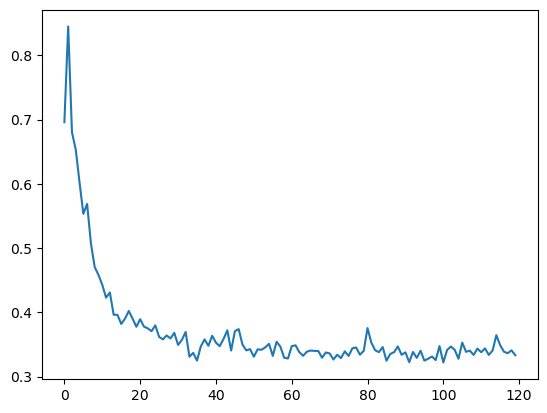

In [337]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

loss_train = train(model=model, optimizer=optimizer, epoch=2, criterion=criterion)
plt.plot(loss_train)

In [340]:
# model evaluation
evaluate(model, criterion)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5099
           1       0.71      0.87      0.78       265

    accuracy                           0.98      5364
   macro avg       0.85      0.93      0.88      5364
weighted avg       0.98      0.98      0.98      5364

The average accuracy in test data is 0.9759507829977628
The average F1-score in test data is 0.9759507829977628


#### Appendix: A Job Description on LinkedIn

In [344]:
# refonte infini test
refonte_jd = """

About the job
Refonte Infini is a leading IT corporation globally recognized for its expertise in providing top-notch IT and Ed-tech services. Specializing in Artificial intelligence (AI), digital marketing, data science, data analytics, UI-UX design, web development, and app development, we are dedicated to innovation, excellence, and empowering talents worldwide.


Job Title: AI, Data Science, DevOps, and Cloud Intern


Benefits:

This internship offers an exciting opportunity to gain practical experience in AI, Data Science, DevOps, and Cloud technologies, working on impactful projects and contributing to the development of innovative solutions. If you are enthusiastic about technology and eager to learn, we encourage you to apply and join our team.


Learn More: https://refontelearning.com



Job Summary:



Refonte Learning is seeking enthusiastic individuals for our prestigious AI & Data Science Study and Internship Program. This intensive initiative offers a unique opportunity to collaborate closely with our seasoned AI & data science team on diverse and impactful projects.


Refonte Learning is seeking enthusiastic individuals who are looking to learn AI & Data Science from beginning to advanced level while also working on live projects globally. RIGTIP (Refonte Infini Global Training & Internship Program) is designed as a manner that offers you to work in a flexible work environment but also offers working with people in a global team from Oceania, Asia, Europe and American continents.


Job Description:

We are excited to offer an internship opportunity for individuals passionate about the convergence of AI, Data Science, DevOps, and Cloud technologies. As an AI, Data Science, DevOps, and Cloud Intern, you will have the unique opportunity to gain hands-on experience in these dynamic and interconnected fields, working on innovative projects and collaborating with experienced professionals.


Responsibilities:

Collaborate with cross-functional teams to develop, deploy, and maintain AI-driven solutions.
Assist in collecting, cleaning, and analyzing data from various sources to derive actionable insights.
Contribute to the design and implementation of scalable data pipelines for model training and deployment.
Support the integration of machine learning models into production systems using DevOps best practices.
Participate in designing and optimizing CI/CD pipelines for continuous integration, testing, and deployment of AI applications on cloud platforms.
Assist in infrastructure provisioning, configuration, and monitoring using cloud services such as AWS, Azure, or Google Cloud.
Work closely with data scientists and engineers to understand business requirements and translate them into technical solutions.
Research and experiment with emerging technologies and tools in AI, Data Science, DevOps, and Cloud domains.
Collaborate on documentation efforts to ensure knowledge sharing and best practices across the team.


Projects You Will Work On:

- Multi Cloud AI Infrastructure Configuration, Automation and Deployment
- Full Stack AI DevOps & Development
- Generative AI model, Large Language Models and Foundations models to transform input to output.
NB: Input can be text, images, audios or videos; Output can also be text, images, audios or videos
- Finance Fraud Detection: Develop advanced fraud detection algorithms leveraging financial data analysis.
- Recommender System: Contribute to personalized recommendation systems, enhancing user experiences across platforms.
- Sentiment Analysis: Explore sentiment analysis to extract insights from textual data, shaping user sentiment understanding.
- Chatbots: Engage in intelligent chatbot development, revolutionizing customer interactions and support.
- Image/Audio Video Classification: Push boundaries with multimedia technology by working on image and audio video classification projects.
- Text Analysis: Uncover hidden patterns in textual data through sophisticated text analysis techniques.


Roles & Responsibilities:

- Collaborate with our esteemed AI & data science experts to collect, clean, and analyze extensive datasets, honing skills in data preprocessing and visualization.
- Contribute to the development of predictive models and algorithms, employing cutting-edge machine learning techniques to solve real-world challenges.
- Work closely with team members to design, implement, and evaluate experiments, fostering a collaborative and innovative environment.
- Stay updated with the latest industry trends and best practices in data science, applying newfound knowledge to enhance project outcomes.
Qualifications:
- Currently pursuing any degree showcasing a strong commitment to continuous learning and professional growth.
- Exceptional written and verbal communication skills, vital for effective collaboration and articulation of complex ideas.
- Demonstrated ability to work both independently and as part of a cohesive team, highlighting adaptability and strong teamwork capabilities.


Benefits:



This internship offers an exciting opportunity to gain practical experience in AI, Data Science, DevOps, and Cloud technologies, working on impactful projects and contributing to the development of innovative solutions. If you are enthusiastic about technology and eager to learn, we encourage you to apply and join our team.


Note:

This position is part of our unpaid AI & Data Science Study and Internship Program. Upon application, our team will contact you to proceed with the application details and joining process.


Location:

Remote, United States


Contact:

To explore the exciting world of data science with us, please contact us at admin@refontelearning.com
Thank you for considering Refonte Infini Private Limited for your professional development in the field of data science. We look forward to welcoming you to our dynamic team.
"""

In [346]:
import regex as re

def text_preprocessing(text):
    text = re.sub(r'([a-z])([A-Z]|[0-9])', r'\1 \2', text) # deal with concated words such as "MyJob"
    text = re.sub(r'https?:?[\S]+', ' ', text) # deal with URL
    text = re.sub(r'#?URL[\S]+', ' ', text) # deal with "#URL_abcdefg"
    text = re.sub(r'[_]+', ' ', text) # deal with "_"
    
    text = re.sub(r'\W', ' ', text) # just remain the alphanumeric characters
    
    word_list = []
    for word in text.split():
        word = word.lower()
        if len(word) <= 2 or \
            re.findall(r'^[0-9]+', word) or \
            word == 'nan':
                continue
        
        word_list.append(word)
    
    return ' '.join(word_list)

refonte_jd = text_preprocessing(refonte_jd)
refonte_jd

'about the job refonte infini leading corporation globally recognized for its expertise providing top notch and tech services specializing artificial intelligence digital marketing data science data analytics design web development and app development are dedicated innovation excellence and empowering talents worldwide job title data science dev ops and cloud intern benefits this internship offers exciting opportunity gain practical experience data science dev ops and cloud technologies working impactful projects and contributing the development innovative solutions you are enthusiastic about technology and eager learn encourage you apply and join our team learn more job summary refonte learning seeking enthusiastic individuals for our prestigious data science study and internship program this intensive initiative offers unique opportunity collaborate closely with our seasoned data science team diverse and impactful projects refonte learning seeking enthusiastic individuals who are loo

In [354]:
refonte_jd = text_adjust_encode([list(refonte_jd.split())], word2idx, max_len)
refonte_jd

array([[258,  22, 189, ...,   0,   0,   0]])

In [361]:
refonte_dataloader = generate_dataloader(refonte_jd, [1])

In [372]:
with torch.no_grad():
    for i, (x, y) in enumerate(refonte_dataloader):
        logit = model(x)
        pred = torch.softmax(logit, dim=1)
        print(f"The probability of scam job is {pred[0][1]:.2%} and real job is {pred[0][0]:.2%}")

The probability of scam job is 0.00% and real job is 100.00%
